In [21]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

#from matplotlib import pyplot
import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [22]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [23]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [24]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("---------------------------------------")

## XGBoost Without PCA and without Feature Engineering


In [5]:
files = ['CompleteWeeklyIndexes', 'MeanWeeklyImputed', 'KNNWeeklyImputed', 'MovingAverageWeeklyImputed', 'RegressionWeeklyImputed', 'MIIWeeklyImputed']

for file in files:
    if "Complete" in file:
        df = read_csv('output/\/'+file+'.csv')
        print(file)
        X_test = df.loc['2015-01-02':]
        df.fillna(0)
        X_test.fillna(0)
        
    else:
        df = read_csv('output/\/'+file+'_training.csv')
        print(file)
        X_test = read_csv('output/\/'+file + '_test.csv')
    
    
    
    y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
    y.index = y['date'].values
    y = y[['regime']]
    y = y['regime']=='BEAR'
    y = pd.DataFrame (y, columns = ['regime'])
       

    X_train = df.loc['2000-01-01':'2015-01-01']
    X_test = X_test.loc['2015-01-02':]
    y_train = y.loc['2000-01-01':'2015-01-01']
    y_test = y.loc['2015-01-02':]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    param_test1 = {
        'learning_rate':[0.01, 0.1],
        'n_estimators':[500, 1000],
        'max_depth':range(2,6,1),
        'subsample':np.arange(0.8,1,0.1),
        'min_child_weight':range(1,6,2),
        'colsample_bytree':np.arange(0.3,1,0.2),
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
    gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                          eval_metric = 'auc',
                                                          #disable_default_eval_metric = 1,
                                                          gamma=1,
                                                          #scale_pos_weight=balance
                                                          ), 
                            param_grid = param_test1, 
                            #scoring='f1',
                            n_jobs=4,
                            cv=tscv)

    gsearch1.fit(X_train, y_train)#, eval_metric=f1_eval)
    print(gsearch1.best_params_, gsearch1.best_score_)

    y_train_pred = gsearch1.predict(X_train)
    print("_______________________________________")
    print("______________Training_________________")
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_score = 2*precision*recall/(precision+recall)  
    print("F1 score", f_score)
    print_confusion_matrix(tn, fp, fn, tp)
    print("_______________Testing_________________")
    y_pred = gsearch1.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_score = 2*precision*recall/(precision+recall)
    print("F1 score", f_score)
    print_confusion_matrix(tn, fp, fn, tp)
    print("---------------------------------------")


CompleteWeeklyIndexes
{'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8} 0.6717948717948717
_______________________________________
______________Training_________________
F1 score 0.9756756756756757
     True False
True    361    7
False   11    403
_______________________________________
---------------------------------------
_______________Testing_________________
F1 score 0.6491228070175438
     True False
True    37    12
False   28    195
_______________________________________
---------------------------------------
---------------------------------------
MeanWeeklyImputed
{'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.8} 0.5452991452991452
_______________________________________
______________Training_________________
F1 score 0.9714285714285714
     True False
True    357    6
False   15    404
_

In [25]:
best_params = {
    'CompleteWeeklyIndexes': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8},
    'MeanWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8},
    'KNNWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 1000, 'subsample': 0.8},
    'MovingAverageWeeklyImputed': {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8},
    'RegressionWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.9},
    'MIIWeeklyImputed': {'colsample_bytree': 0.9000000000000001, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}
}

files = ['CompleteWeeklyIndexes', 'MeanWeeklyImputed', 'KNNWeeklyImputed', 'MovingAverageWeeklyImputed', 'RegressionWeeklyImputed', 'MIIWeeklyImputed']

In [98]:
def format(val, pos):
    if val == 0:
        return "BULL"
    if val == 1:
        return "BEAR"
    else:
        return ""

In [112]:
def plot(real, imputed):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    ax.plot(real.index, real, '-', label="Real Data", color='blue')
    ax.plot(real.index, imputed, '-', label="Imputed Data", color='red')
    ax.legend(['Real Data', 'Predicted Data'])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format))
    ax.set_ylim(-0.1, 1.1)
    fig.autofmt_xdate()
    plt.show()

In [113]:
def run_experiment_multiple_times(best_params, files, n=30):
    result_dict = {}
    for file in files:
        print(file)
        result_dict[file] = {'f1':0, 'tn':0, 'fp':0, 'fn':0, 'tp':0, 'best_f1':0, 'best_model':None, 'best_f1':0, 'best_tn':0, 'best_fp':0, 'best_fn':0, 'best_tp':0}
        if "Complete" in file:
            df = read_csv('output/\/'+file+'.csv')
            X_test = df.loc['2015-01-02':]
            df.fillna(0)
            X_test.fillna(0)

        else:
            df = read_csv('output/\/'+file+'_training.csv')
            X_test = read_csv('output/\/'+file + '_test.csv')


        y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
        y.index = y['date'].values
        y = y[['regime']]
        y = y['regime']=='BEAR'
        y = pd.DataFrame (y, columns = ['regime'])


        X_train = df.loc['2000-01-01':'2015-01-01']
        X_test = X_test.loc['2015-01-02':]
        y_train = y.loc['2000-01-01':'2015-01-01']
        y_test = y.loc['2015-01-02':]
        
        for i in range(0,n):
            balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
            xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                              eval_metric = 'auc',
                                              learning_rate=best_params[file]['learning_rate'], 
                                              n_estimators=best_params[file]['n_estimators'], 
                                              min_child_weight=best_params[file]['min_child_weight'], 
                                              gamma=1, 
                                              max_depth=best_params[file]['max_depth'],
                                              subsample=best_params[file]['subsample'],
                                              colsample_bytree=best_params[file]['colsample_bytree'],
                                          )

            model = xgb_model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)
            f_score = (2*precision*recall/(precision+recall))
            result_dict[file]['f1'] += f_score
            result_dict[file]['tn'] += tn
            result_dict[file]['fp'] += fp
            result_dict[file]['fn'] += fn
            result_dict[file]['tp'] += tp
            if result_dict[file]['best_f1'] < f_score:
                result_dict[file]['best_f1'] = f_score
                result_dict[file]['best_model'] = model
                result_dict[file]['best_tn'] = tn
                result_dict[file]['best_fp'] = fp
                result_dict[file]['best_fn'] = fn
                result_dict[file]['best_tp'] = tp
       
        #plot bear bull imputed and real
        plot(y_test, y_pred)
        # feature importance
        data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
        data.plot(kind='barh', title=file, figsize=(10,10))
        
        result_dict[file]['f1'] = result_dict[file]['f1']/n
        result_dict[file]['tn'] = result_dict[file]['tn']/n
        result_dict[file]['fp'] = result_dict[file]['fp']/n
        result_dict[file]['fn'] = result_dict[file]['fn']/n
        result_dict[file]['tp'] = result_dict[file]['tp']/n
        
    return result_dict     

CompleteWeeklyIndexes


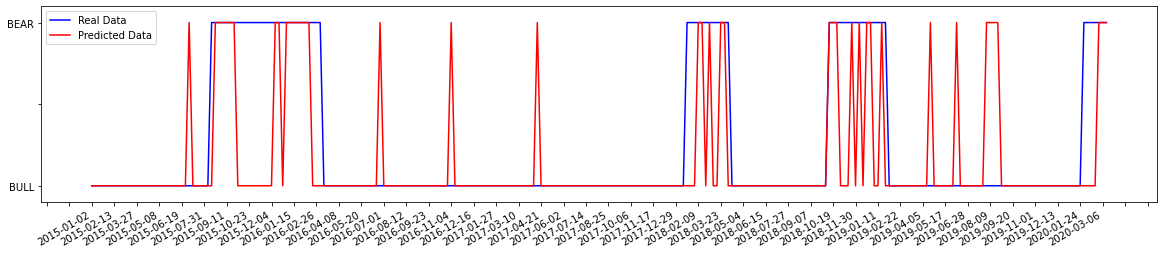

MeanWeeklyImputed


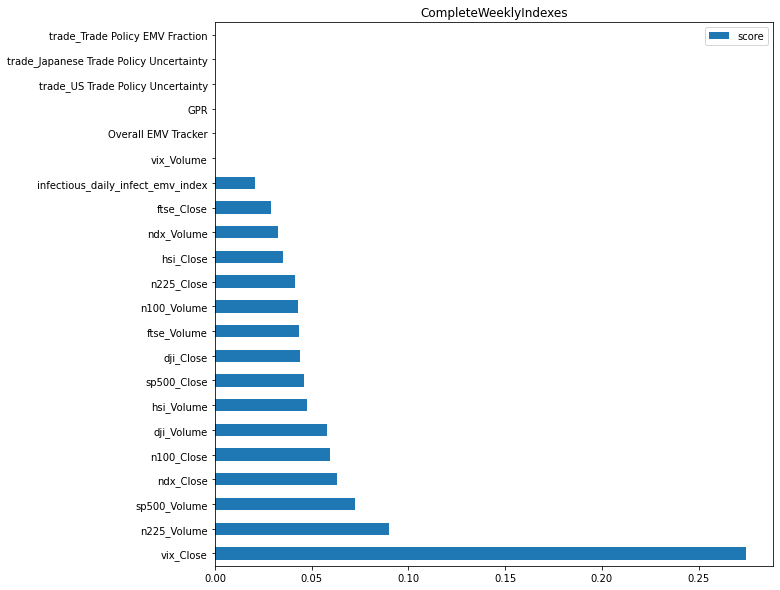

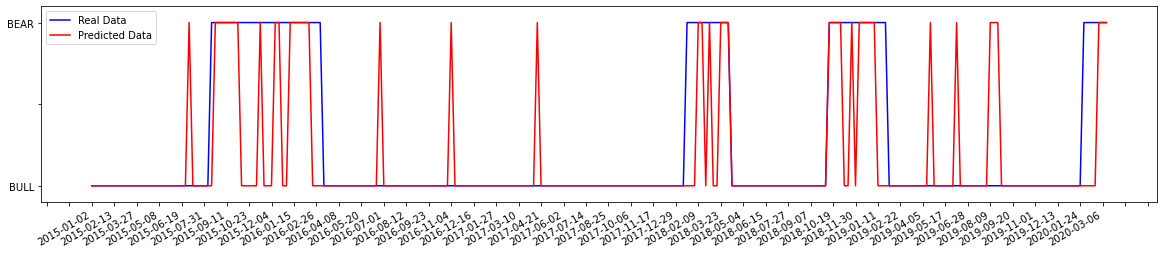

KNNWeeklyImputed


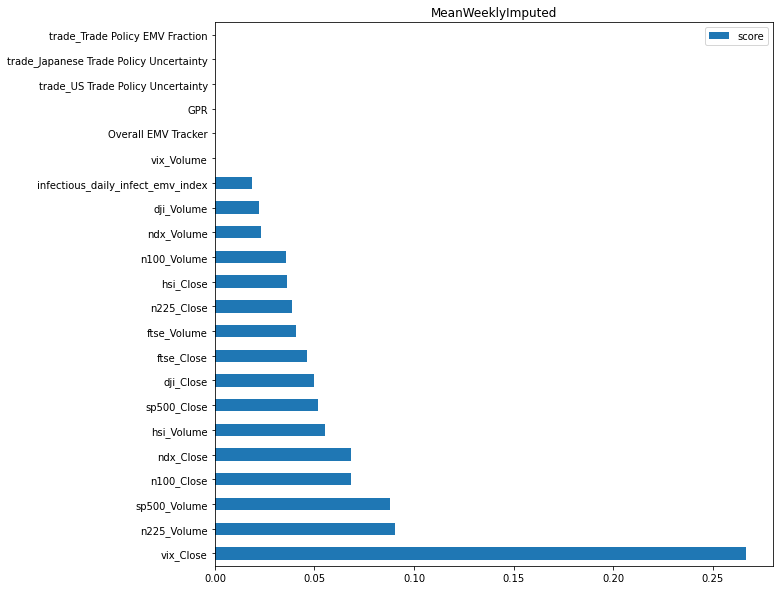

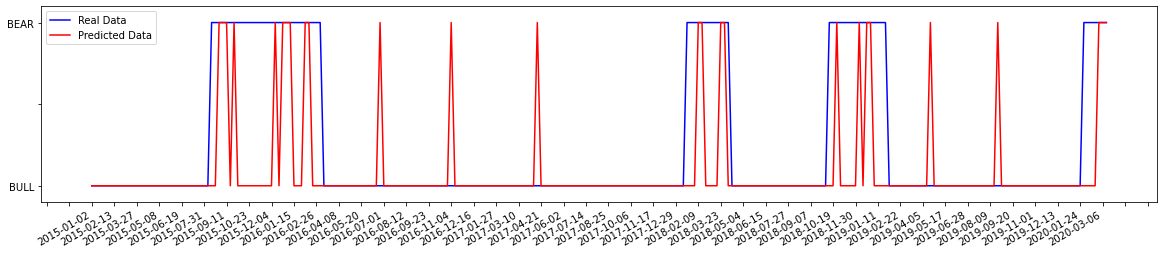

MovingAverageWeeklyImputed


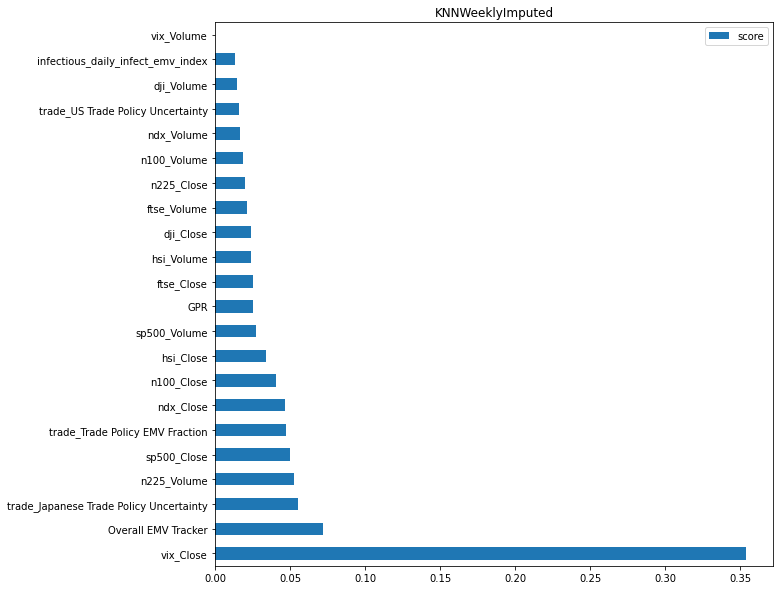

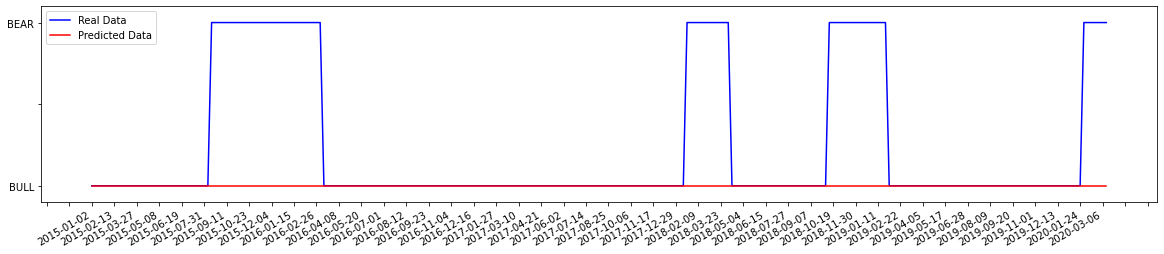

RegressionWeeklyImputed


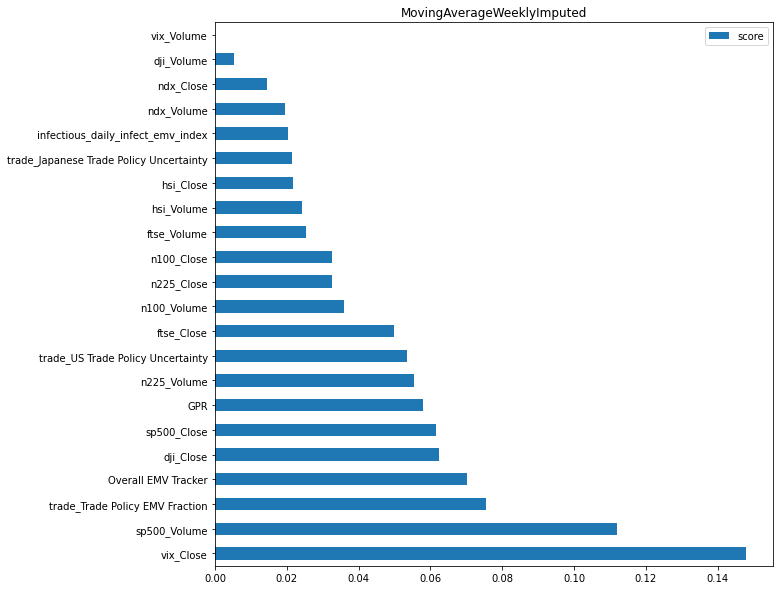

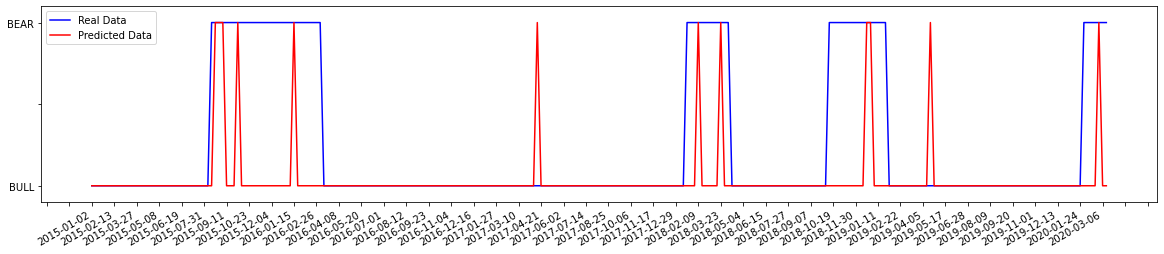

MIIWeeklyImputed


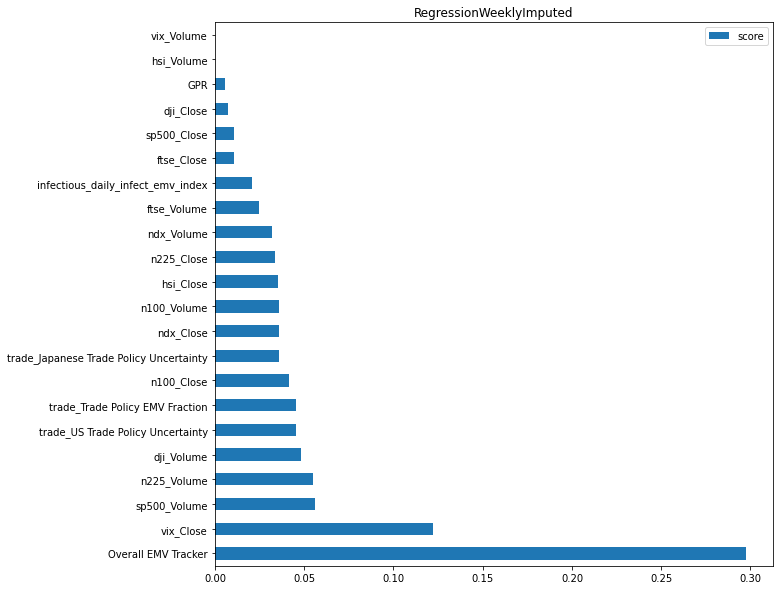

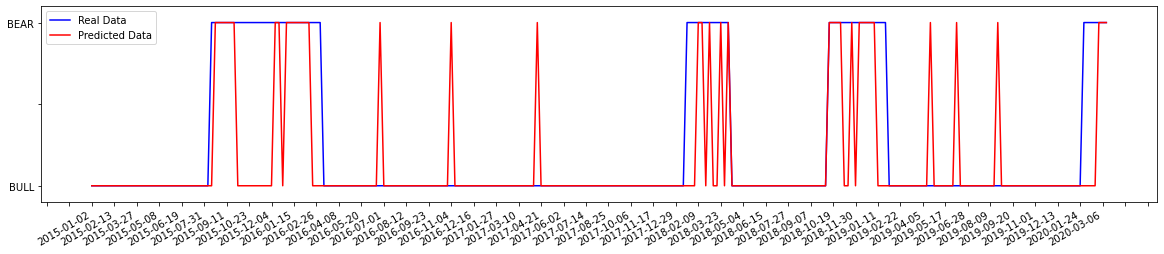

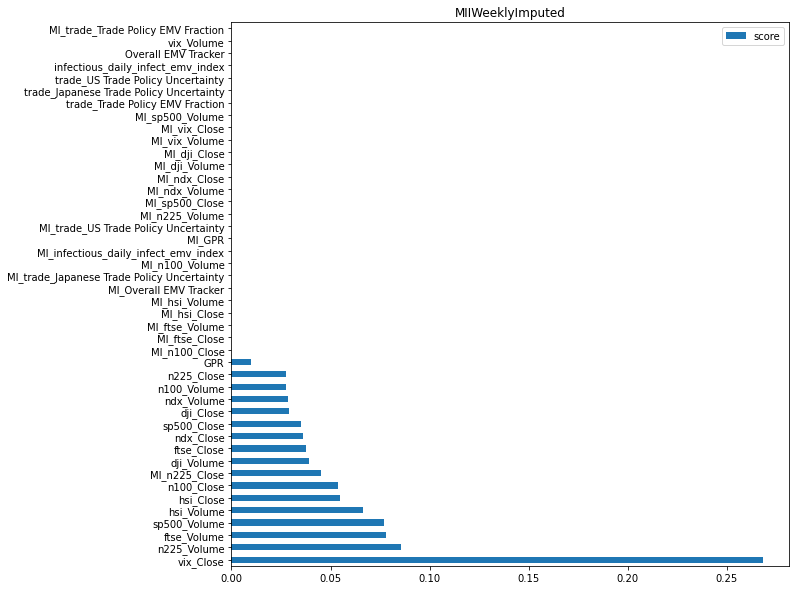

In [114]:
result_dict = run_experiment_multiple_times(best_params, files, n=1)

In [111]:
result_dict

{'CompleteWeeklyIndexes': {'f1': 0.5849056603773585,
  'tn': 197.0,
  'fp': 10.0,
  'fn': 34.0,
  'tp': 31.0,
  'best_f1': 0.5849056603773585,
  'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.9000000000000001,
                eval_metric='auc', gamma=1, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.01, max_delta_step=0,
                max_depth=4, min_child_weight=5, missing=nan,
                monotone_constraints='()', n_estimators=500, n_jobs=0,
                num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
                scale_pos_weight=1, subsample=0.8, tree_method='exact',
                validate_parameters=1, verbosity=None),
  'best_tn': 197,
  'best_fp': 10,
  'best_fn': 34,
  'best_tp': 31},
 'MeanWeeklyImputed': {'f1': 0.6422018348623854,
  'tn': 198.0,
  'fp': 9.0,
  'fn': 30.0,
  'tp': 35.0,
  'best_f1': 0.6422018

In [10]:
for key, item in result_dict.items():
    print(key)
    print("Average F1 Score", item['f1'])
    print_confusion_matrix(item['tn'], item['fp'], item['fn'], item['tp'])
    print("_______________________________________________________________________________")
    print("Best F1 Score", item['best_f1'])
    print_confusion_matrix(item['best_tn'], item['best_fp'], item['best_fn'], item['best_tp'])
    print("_______________________________________________________________________________")

CompleteWeeklyIndexes
Average F1 Score 0.5849056603773585
     True False
True    31.0    10.0
False   34.0    197.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
Best F1 Score 0.5849056603773585
     True False
True    31    10
False   34    197
_______________________________________
---------------------------------------
_______________________________________________________________________________
MeanWeeklyImputed
Average F1 Score 0.6422018348623854
     True False
True    35.0    9.0
False   30.0    198.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
Best F1 Score 0.6422018348623854
     True False
True    35    9
False   30    198
_______________________________________
---------------------------------------
____________________________________________